In [1]:
!pip install torch_optimizer
!pip install pyhessian

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 587 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import LeNet
import Optimizers
import pyhessian
from Helpers import *

#### Data load

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
batch_size = 100
learning_rate = 0.1

In [6]:
import torchvision
import torchvision.datasets as datasets
import os

In [7]:
if not os.path.isdir('./data/mnist'):
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
else:
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



In [8]:
type(mnist_trainset)

torchvision.datasets.mnist.MNIST

In [9]:
train_data_tmp = [mnist_trainset[i][0] for i in range(len(mnist_trainset))]
tmp = torch.Tensor(len(mnist_trainset),1, 32, 32)
train_data = torch.cat(train_data_tmp, out=tmp)
train_data = train_data.reshape(len(train_data),1,32,32).to(device)

train_target = torch.Tensor([[mnist_trainset[i][1] for i in range(len(mnist_trainset))]]).reshape(-1)
train_target = train_target.long().to(device)

In [10]:
test_data_tmp = [mnist_testset[i][0] for i in range(len(mnist_testset))]
tmp = torch.Tensor(len(mnist_testset),1, 32, 32)
test_data = torch.cat(test_data_tmp, out=tmp)
test_data = test_data.reshape(len(test_data),1,32,32).to(device)

test_target = torch.Tensor([[mnist_testset[i][1] for i in range(len(mnist_testset))]]).reshape(-1)
test_target = test_target.long().to(device)

#### Model training

In [17]:
epochs = 150

In [18]:
def train(model, train_data, train_target, name, lr = 0.1):
    optimizer = Optimizers.get_optimizer(model, name, lr)
    loss = nn.CrossEntropyLoss()
    grad_norm = []
    for i in range(epochs):
        for b in range(0,train_data.size(0), batch_size):
            optimizer.zero_grad()
            train_batch_data = train_data[b : b + batch_size]
            train_batch_target = train_target[b : b + batch_size]
            y_hat = model(train_batch_data)
            l = loss(y_hat, train_batch_target)
            if name.lower() == 'adahessian':
                l.backward(create_graph = True)
            else:
                l.backward()
            optimizer.step()
        grad_norm.append(norm_gradient(model))
        if i % 10 == 0:
          print(i)
    return model, grad_norm

In [19]:
def test(model, test_data, test_target):
  nb_errors  = 0
  i = 0
  for b in range(0,test_data.size(0), batch_size):
    with torch.no_grad():
      y_hat = model(test_data[b:b+batch_size])
      _, pr = y_hat.max(1)
      for k in range(batch_size):
        if pr[k] != test_target[k + b]:
          nb_errors += 1
  return (test_data.size(0)-nb_errors)/test_data.size(0)

In [20]:
first_order = ['adam', 'sgd', 'adagrad']
#first_order = ['sgd']
second_order = ['adahessian']
first_order_perf = {}
second_order_perf = {}

In [21]:
for first_order_method in first_order:
  print(first_order_method)
  model = LeNet.LeNet(batch_size).to(device)
  model, grad_norms = train(model, train_data, train_target,first_order_method)
  error = test(model, test_data, test_target)
  first_order_perf[first_order_method] = (error,model,grad_norms)
  print(error)
  print("------------------------------------------------------------")

adam
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.101
------------------------------------------------------------
sgd
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.9902
------------------------------------------------------------
adagrad
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.1028
------------------------------------------------------------


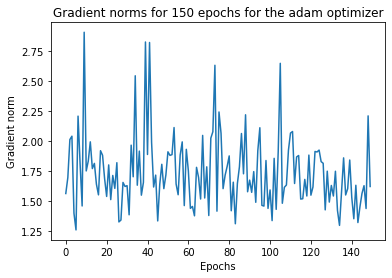

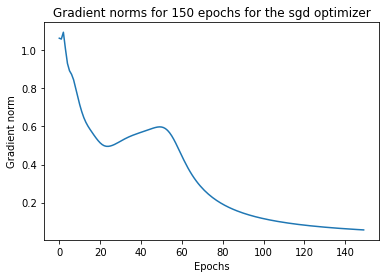

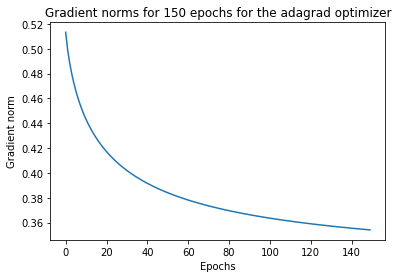

In [22]:
for k, value in first_order_perf.items():
  opt_name = k
  grad_norms = value[-1]
  plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

In [23]:
for second_order_method in second_order:
  print(second_order_method)
  model = LeNet.LeNet(batch_size).to(device)
  model, grad_norms = train(model, train_data, train_target,second_order_method)
  error = test(model, test_data, test_target)
  second_order_perf[second_order_method] = error,model,grad_norms
  print("------------------------------------------------------------")

adahessian


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
------------------------------------------------------------


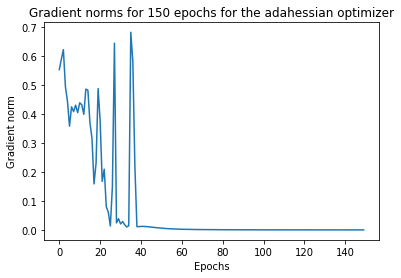

In [24]:
for k, value in second_order_perf.items():
  opt_name = k
  grad_norms = value[-1]
  plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

In [ ]:
optimizers_to_top_5_eigenvalues = {}
optimizers_to_hessian_trace = {}
i = 0
model_batch_size = 60_000
inputs, targets = train_data[model_batch_size*i:model_batch_size*(i+1)],train_target[model_batch_size*i:model_batch_size*(i+1)]
model = first_order_perf["sgd"][1]
model.batch_size = model_batch_size
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()

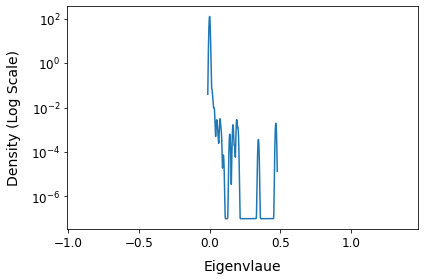

In [ ]:
get_esd_plot(density_eigen, density_weight)

In [ ]:
"""for k, value in first_order_perf.items():
  opt_name = k
  criterion = nn.CrossEntropyLoss()
  model = first_order_perf[opt_name][1]
  model.batch_size = model_batch_size
  hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
  top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=5, maxIter=100000)
  trace = np.mean(hessian_comp.trace(maxIter=100000))
  optimizers_to_top_5_eigenvalues[opt_name] = (top_eigenvalues, top_eigenvectors)
  optimizers_to_hessian_trace[opt_name] = trace"""

'for k, value in first_order_perf.items():\n  opt_name = k\n  criterion = nn.CrossEntropyLoss()\n  model = first_order_perf[opt_name][1]\n  model.batch_size = model_batch_size\n  hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)\n  top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=5, maxIter=100000)\n  trace = np.mean(hessian_comp.trace(maxIter=100000))\n  optimizers_to_top_5_eigenvalues[opt_name] = (top_eigenvalues, top_eigenvectors)\n  optimizers_to_hessian_trace[opt_name] = trace'

In [ ]:
"""for k, value in second_order_perf.items():
  opt_name = k
  inputs, targets = train_data[model_batch_size*i:model_batch_size*(i+1)],train_target[model_batch_size*i:model_batch_size*(i+1)]
  criterion = nn.CrossEntropyLoss()
  model = second_order_perf[opt_name][1]
  model.batch_size = model_batch_size
  hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
  top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=5, maxIter=100000)
  trace = np.mean(hessian_comp.trace(maxIter=100000))
  optimizers_to_top_5_eigenvalues[opt_name] = (top_eigenvalues, top_eigenvectors)
  optimizers_to_hessian_trace[opt_name] = trace"""

'for k, value in second_order_perf.items():\n  opt_name = k\n  inputs, targets = train_data[model_batch_size*i:model_batch_size*(i+1)],train_target[model_batch_size*i:model_batch_size*(i+1)]\n  criterion = nn.CrossEntropyLoss()\n  model = second_order_perf[opt_name][1]\n  model.batch_size = model_batch_size\n  hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)\n  top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=5, maxIter=100000)\n  trace = np.mean(hessian_comp.trace(maxIter=100000))\n  optimizers_to_top_5_eigenvalues[opt_name] = (top_eigenvalues, top_eigenvectors)\n  optimizers_to_hessian_trace[opt_name] = trace'

In [ ]:
"""optimizers_to_hessian_trace"""

{'adagrad': 78.11551074492625,
 'adahessian': 0.008181575585954956,
 'adam': 73.865553855896,
 'sgd': 3.3814347783724465}